In this tutorial, we would like to implement VALMOD algorithm proposed in paper [VALMOD](https://arxiv.org/pdf/2008.13447.pdf), and reproduce its results as closely as possible.

The **VAriable Length MOtif Discovery (VALMOD)** algorithm takes time series `T` and a range of subsequence length `[min_m, max_m]`, and find motifs and discords.

In [96]:
%matplotlib inline

import stumpy
from stumpy import core, config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# 1- Introduction

Some important notations that we may use later:
* subsequence $T_{i,m}$ --> a subsequence of `T` that starts at index `i` and has length `m` 
* Motif set $S^{m}_{r}$ (for a given motif pair $\{T_{idx,m},T_{nn\_idx,n}\}$) --> is a set of subsequences of length `m` that has `distance < r` to either $T_{idx,m}$ or $T_{nn\_idx,n}$. And, the cardinality of set is called the frequency of the motif set.

### Motif discovery

We would like to find set $S^{*} = \bigcup\limits_{m=min\_m}^{max\_m}{S^{m}_{r}}$, and $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$. In other words, we want to find motif sets for different length `m` and we want to make sure there is no "common" (see note below) subsequence between any two motif sets. 

**NOTE:** The subsequences in motif set of length m and m' are indeed different because they have different length. However, by the constraint $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$, the authors meant to avoid considering two subsequences (of different length) that start from the same index. For instance, if $T_{200,m}$ is in one set and $T_{200,m'}$ in another set, the authors consider the intersection of their corresponding set to be non-empty because both these two subsequences start from the same index.

### Discord discovery

First, we need to provide a few definitions...

**$n^{th}$ best match**: For the subsequence $T_{i,m}$, its $n^{th}$ best match is simply the $n^{th}$ smallest distance in the distance profile. <br>

**$n^{th}$ discord**: a subsequence $T_{i,m}$ is the $n^{th}$ discord  if it has the largest value to its $n^{th}$ best match compared to the distances between any other subsequence and its ($n^{th}$ ?) best match. <br>

**NOTE**:<br>
Why should I care about $n^{th}$ discord (n>1)? We provide a simple example below:

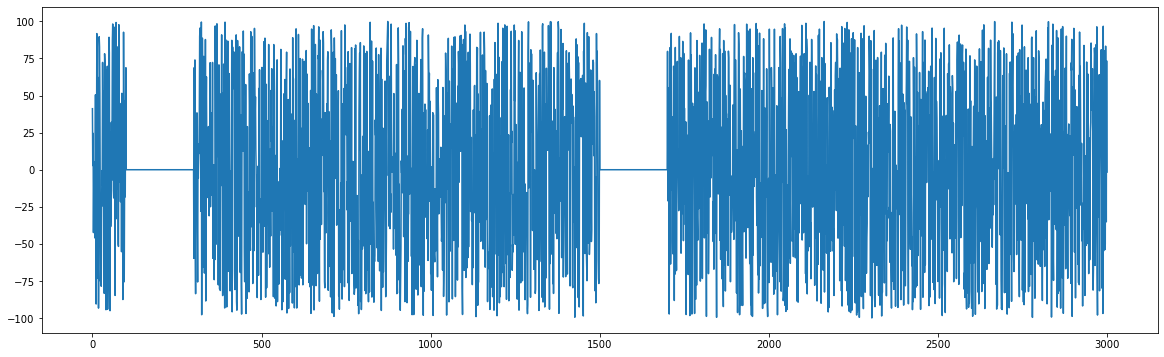

In [97]:
T = np.random.uniform(-100,100,size=3000)
m = 200
i, j = 100, 1500

T[i:i+m] = 0
T[j:j+m] = 0

plt.plot(T)
plt.show()

Here, the subsequences at index `i` and `j` can be considered an anomaly. However, the 1NN distance is 0 for them. Therefore, we may need to investigate other neighbors rather than just 1NN. 

For further details, see Fig. 2 of the paper. Notice that `Top-1 2nd discord` subsequence has a close 1-NN; however, it is far from its 2nd closest neighbor.)

**Variable-length Top-k $n^{th}$ Discord Discovery:** <br>
Given a time series `T`, a subsequence length-range `[min_m, max_m]`,`K`, and `N`, we want to find **top-k $n^{th}$ discord** for each `k` in $\{1,...,K\}$, for each `n` in $\{1,...,N\}$, and for all `m` in $\{min\_m,...,max\_m\}$.

# 2- Lower-Bound Distance Profile (for z-normalize case)

The idea goes as follows: "given the distance profile of $T_{j,m}$, how can I find a lower bound for distance profile of $T_{j,m+k}$", where $T_{j,m+k}$ represents a sequence that starts from the same index `j` with length `m+k`?

In other words, can I find lower bound for $d(T_{j,m+k}, T_{i,m+k})$ only by help of $T_{j,m}$, $T_{i,m}$, and $T_{j,m+k}$? If I can find that, it means I can find the lower-bound for the distance profile of the query $T_{j,m+k}$.

$d^{(m+k)}_{j,i} \ge \min{(d)}$, where $d$ is:

$d = \sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}})^{2}
}
}$, where ($\mu_{i,m+k}$, $\sigma_{i,m+k}$), and ($\mu_{j,m+k}$, $\sigma_{j,m+k}$) are (mean, standard deviation) of subsequences $T_{i,m+k}$ and $T_{j,m+k}$, respectively.

**Note:** The values $\mu_{j,m+k}$ and $\sigma_{j,m+k}$ are known. The goal is to find its lower-bound distane to its neighbor `i` (i.e. $T_{i,m+k}$) without using its last `k` elements! The value $d$ shown above is the z-normalized distance between $T_{j,m+k}$ and $T_{i,m+k}$ considering only the `m` first elements. We know that it is already less than $d^{(m+k)}_{j,i}$. So, by minimizing the Right Hand Side of inequation, we can get the Lower Bound (LB).

Factoring out $\frac{1}{\sigma_{j,m+k}}$ --> Therefore: $d = \frac{1}{\sigma_{j,m+k}}\sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu_{i,m+l}}{\frac{\sigma_{i,m+k}}{\sigma_{j,m+k}}} - \frac{T[j+t-1] - \mu_{j,m+k}}{1})^{2}
}
}$ 

mulitply by $\frac{\sigma_{j,m}}{\sigma_{j,m}}$ --> Therefore: $\frac{\sigma_{j,m}}{\sigma_{j,m+k}}\sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu_{i,m+k}}{\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}})^{2}
}
}$



Now, we replace $\mu_{i,m+k}$ with $\mu^{'}$, and $\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}$ with $\sigma^{'}$, so we have:

$d = \frac{\sigma_{j,m}}{\sigma_{j,m+k}}\sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}})^{2}
}
}$



**Important Note:**<br>
Note the typo in eq(1) of the paper...
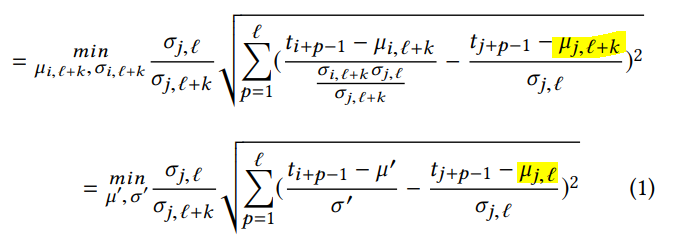

Somehow, the authors change $\mu_{j,m+k}$ to $\mu_{j,k}$...However, these two values can be different.

**>>> In this notebook: <br>
we try to calculate LB after correcting such typo. The problem becomes...**

**To find the minimum value of d, we need to minimize the following function:**

$f(\mu^{'}, \sigma^{'}) = \sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}})^{2}
}$ <br>

**Let's take its partial derivatives and put them equal to 0...** <br>
$\frac{\partial f}{\partial \mu^{'}} = 0$ <br>
$\frac{\partial f}{\partial \sigma^{'}} = 0$

**First, let us first provide some guidelines:** <br>

(1) We use $T_{i}$ to represent $T[i+t-1]$, and $T_{j}$ to represent $T[j+t-1]$. Since we use them inside $\sum$, the notation should suffice. <br>
(2) We use $\sum$ without limits. It is alway from $t=1$ to $m$. <br>
(3) We define: $X_{t} = \frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}$ <br>
(4) Similar to paper, We define: $q = \frac{\sum{T_{i}T_{j}} - m\mu_{i,m}\mu_{j,m}}{m\sigma_{i,m}\sigma_{j,m}}$ (note: $q=1$ for $i=j$)<br>
(5) Note that: $\sum{T_{i}} = m\mu_{i,m}$, and $T_{j} = m\mu_{j,m}$.
(6) We use $\mu_{j}$ and $\sigma_{j}$ to represent $\mu_{j,m}$ and $\sigma_{j,m}$, respectively. If we want to show $\mu$ for length `m+k`, we use $\mu_{j,m+k}$

**Let us solve it...**

(1) $\frac{\partial f}{\partial \mu^{'}} = 0$ <br>

Therefore: $\sum{\frac{-2}{\sigma^{'}}X_{t}} = 0$ <br>
Therefore: $\sum{X_{t}} = 0$ (eq: I)

(2) $\frac{\partial f}{\partial \sigma^{'}} = 0$ <br>
 
Therefore: $\sum{\frac{-2}{\sigma^{'2}}(T_{i} - \mu^{'})X_{t}} = 0$ <br>
Therefore: $\sum{(T_{i} - \mu^{'})X_{t}} = 0$ <br>
Therefore (using eq I): $\sum{T_{i}X_{t}} = 0$ (eq II)<br>

Also, let us find out the value we are trying to minimize:

$f(\mu^{'}, \sigma^{i}) = \sum{
(\frac{T_{i} - \mu^{'}}{\sigma^{'}} - \frac{T_{j} - \mu_{j,m+k}}{\sigma_{j}})^{2}
} 
= 
\sum{
[(\frac{T_{i} - \mu^{'}}{\sigma^{'}} - \frac{T_{j} - \mu_{j,m+k}}{\sigma_{j}})X_{t}]
} 
= 
{
\frac{\sum{T_{i}X_{t}} - \sum{\mu^{'}X_{t}}}{\sigma^{'}} - \frac{\sum{T_{j}X_{t}} - \sum{\mu_{j,m+k}X_{t}}}{\sigma_{j}}
} $

And, with help of eq I and II, we can see: <br>
$f_{optim} =  - \frac{\sum{(T_{j}X)}}{\sigma_{j}} $

Therefore: <br>
$f_{optim} =  - \frac{1}{\sigma_{j}}F$, where: <br>

$F = \sum{T_{j}X} = \frac{\sum{T_{i}T_{j}} - \sum\mu^{'}T_{j}}{\sigma^{'}} - \frac{\sum{T_{j}T_{j}} - \sum{\mu_{j,m+k}T_{j}}}{\sigma_{j}}$

**We need to find $\mu^{'}$ and $\sigma^{'}$:**

eq I: $\sum{X} = 0$, <br>

Therefore: $\sum{\frac{T_{i} - \mu^{'}}{\sigma^{'}} - \frac{T_{j} - \mu_{j,m+k}}{\sigma_{j}}} = 0$ <br>

Therefore: ${\frac{\sum{T_{i}} - \sum{\mu^{'}}}{\sigma^{'}} - \frac{\sum{T_{j}} - \sum{\mu_{j,m+k}}}{\sigma_{j}}} = 0$ <br>

Therefore: ${\frac{m\mu_{i} - m{\mu^{'}}}{\sigma^{'}} - \frac{m{\mu_{j}} - {\mu_{j,m+k}}}{\sigma_{j}}} = 0$

Therefore: $\sigma_{j}(\mu_{i}-\mu^{'}) - \sigma^{'}(\mu_{j}-\mu_{j,m+k}) = 0$ (eq III)

---

And, with eq II: <br>
$\sum{T_{i}X} = 0$,

Therefore: $\frac{\sum{T_{i}T_{i}} - \sum\mu^{'}T_{i}}{\sigma^{'}} - \frac{\sum{T_{i}T_{j}} - \sum{\mu_{j,m+k}T_{i}}}{\sigma_{j}} = 0$

Therefore: $\sigma_{j}(m\mu_{i}^{2} + m\sigma_{i}^{2} - m\mu_{i}\mu^{'}) - \sigma^{'}(m\mu_{i}\mu_{j} + mq\sigma_{i}\sigma_{j} - m\mu_{i}\mu_{j,m+k}) = 0$ (eq IV)

**solving eq (III) and eq (IV) give us optimal values for $\mu^{'}$ and $\sigma^{'}$ as follows:**

$\sigma^{'} = \frac{\sigma_{i}}{q}$ (thus, q must be positive.)<br>
$\mu^{'} = \mu_{i} - \frac{\sigma^{'}}{\sigma_{j}}(\mu_{j}-\mu_{j,m+k})$

Now, we plugged back in the values to find LB:

$LB = \frac{\sigma_{j,m}}{\sigma_{j,m+k}}\sqrt{f_{optim}}$, where: <br>

$f_{optim} =  - \frac{1}{\sigma_{j}}F$, where: <br> 

$F = \sum{T_{j}X} = \frac{\sum{T_{i}T_{j}} - \sum\mu^{'}T_{j}}{\sigma^{'}} - \frac{\sum{T_{j}T_{j}} - \sum{\mu_{j,m+k}T_{j}}}{\sigma_{j}}$ in which we should use the optimal value for $\mu^{'}$ and $\sigma^{'}$.

* If $q \gt 0$: $LB = \frac{\sigma_{j}}{\sigma_{j,m+k}} \sqrt{m(1-q^{2})}$
* If $q \le 0$:  $LB = \frac{\sigma_{j}}{\sigma_{j,m+k}} \sqrt{m}$ (proof not provided in this notebook)

### LB dist profile function

In [87]:
def _calc_LB_dist_profile(T, D, m, σ, m_target, σ_target):
    """
    This function finds the lower-bound of a distance profile for a subsequence with window size `m_target` based
    on the distance profile of a subsequence with window size `m` starting from the same index `idx`.
    (note: this is for z-normalize case)
    
    Parameters
    ----------
    T: numpy.ndarray
        a time series of interest
        
    D: numpy.ndarray
        Distance profile for a subsequence with length `m` located at an index `idx` in time series `T`
        
    m: int
        length of subsequence for which the the distance profile D is provided. 
    
    σ: float
        standard deviation of subsequence `T[idx : idx + m]`
        
    m_target: int
        new length of subsequence whose lower-bound distance profile will be returned.
    
    σ_target: float
        standard deviation of subsequence `T[idx : idx + m_target]`
        
    Return
    --------
    LB : numpy.ndarray
        Lower_Bound of distance profile for subsequence with length `m_target`, starting at index `idx`.
        
    """
    if m_target <= m:
        raise ValueError(f"m_target, {m_target} should be larget than m, {m}")
    
    if len(D) != T.shape[0] - m + 1:
        raise ValueError(f"length of distance profile D, {len(D)}, should be T.shape[0]-m+1, {T.shape[0]-m+1}")
    
    excl_zone = int(np.ceil(m_target / config.STUMPY_EXCL_ZONE_DENOM))
    
    k = T.shape[0] - m_target + 1
    T_is_finite = core.rolling_isfinite(T, m_target)
    
    R = 1 - np.square(D[:k])/(2 * m)
    
    LB = (σ/σ_target) * np.sqrt(m) * np.sqrt(1 - np.square(np.maximum(R,0)))
    core.apply_exclusion_zone(LB, idx, excl_zone, np.inf)
    LB[~T_is_finite] = np.inf
    
    return LB

**Example:**

In [92]:
T = np.random.uniform(-100,100, size=1000)
idx = 500 #start index of subsequence

In [93]:
m = 10
_, Σ_T = core.compute_mean_std(T, m)
Q = T[idx:idx+m]
excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))

#################################################

m_target = 11
_, Σ_T_target = core.compute_mean_std(T, m_target)
Q_target = T[idx:idx+m_target]
excl_zone_target = int(np.ceil(m_target / config.STUMPY_EXCL_ZONE_DENOM))

In [94]:
D = core.mass(Q, T)
core.apply_exclusion_zone(D, idx, excl_zone, np.inf)

D_target = core.mass(Q_target, T) #true distance profile for length m_target
core.apply_exclusion_zone(D_target, idx, excl_zone, np.inf) 

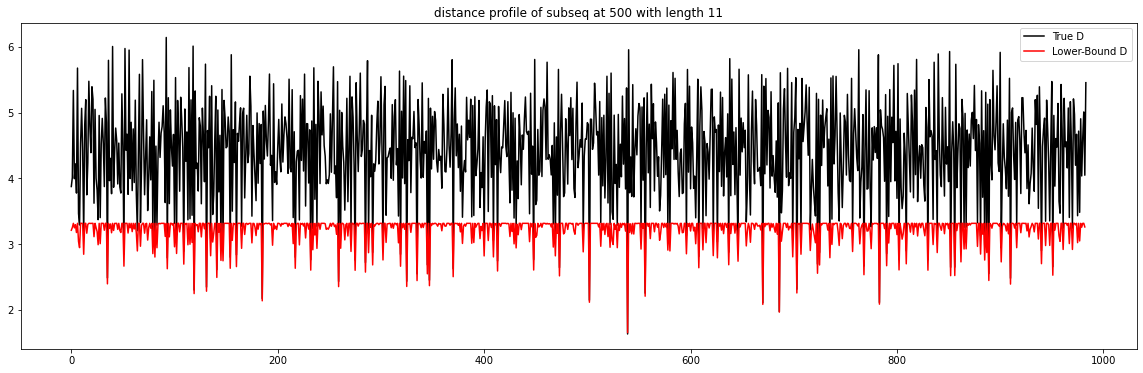

In [95]:
LB = _calc_LB_dist_profile(T, D, m, Σ_T[idx], m_target, Σ_T_target[idx])

plt.title(f'distance profile of subseq at {idx} with length {m_target}')
plt.plot(D[np.isfinite(D)], 'k', label='True D')
plt.plot(LB[np.isfinite(LB)], 'r', label='Lower-Bound D')
plt.legend()
plt.show()